Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

In [24]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump datset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [128]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
#sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val


In [129]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X


**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [130]:
df = wrangle(train)
X_test = wrangle(test)

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [131]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, random_state=42)


# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [133]:
baseline_acc = y_train.value_counts(normalize=True)
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: functional                 0.542971
non functional             0.384091
functional needs repair    0.072938
Name: status_group, dtype: float64


Using matplotlib backend: agg


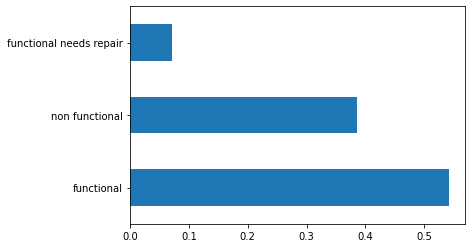

In [58]:
%matplotlib
import matplotlib.pyplot as plt
y_train.value_counts(normalize=True).plot(kind = 'barh')

# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [112]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

model_rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators = 120, max_depth= 20, random_state = 0, n_jobs = -1)
)
model_rf.fit(X_train, y_train);

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [113]:
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.959469696969697
Validation Accuracy Score: 0.8131313131313131


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`. 

In [89]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6
model_rf2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators = 120, max_depth= 20, random_state = 0, n_jobs = -1)
)
model_rf2.fit(X_train, y_train);

training_acc2 = model_rf2.score(X_train, y_train)
val_acc2 = model_rf2.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc2)

Training Accuracy Score: 0.9960015783243457
Validation Accuracy Score: 0.8027146464646465


In [114]:
print('X_train shape before encoding:', X_train.shape)
encoder = model_rf.named_steps['ordinalencoder']
X_encoded = encoder.transform(X_train)
print('X_train shape after encoding:', X_encoded.shape)

X_train shape before encoding: (47520, 45)
X_train shape after encoding: (47520, 45)


In [115]:

print('X_train shape before encoding:', X_test.shape)
encoder = model_rf.named_steps['ordinalencoder']
X_encoded = encoder.transform(X_test)
print('X_train shape after encoding:', X_encoded.shape)

X_train shape before encoding: (14358, 45)
X_train shape after encoding: (14358, 45)


# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [119]:
y_pred = []

y_pred = model_rf.predict(X_test)

assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '
y_pred.shape

(14358,)

In [134]:
X_test.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,years,years_MISSING
0,0.0,Dmdd,1996.0,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321.0,True,Parastatal,NaN,True,2012.0,other,other,other,parastatal,parastatal,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,False,False,False,False,False,2013,2,4,1.0,False
1,0.0,Government Of Tanzania,1569.0,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300.0,True,VWC,TPRI pipe line,True,2000.0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,False,False,False,False,False,2013,2,4,13.0,False
2,0.0,NaN,1567.0,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500.0,True,VWC,P,NaN,2010.0,other,other,other,vwc,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,False,False,False,False,False,2013,2,1,3.0,False
3,0.0,Finn Water,267.0,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250.0,NaN,VWC,NaN,True,1987.0,other,other,other,vwc,user-group,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,False,False,False,False,False,2013,1,22,26.0,False
4,500.0,Bruder,1260.0,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60.0,NaN,Water Board,BRUDER,True,2000.0,gravity,gravity,gravity,water board,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,False,False,False,False,False,2013,3,27,13.0,False


**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site. 

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting. 

In [123]:
submission = pd.DataFrame(y_pred, columns=['status_group'], index = X_test.index)
submission.head()

,status_group
0,functional
1,functional
2,functional
3,non functional
4,functional


In [124]:

#download submission
submission.to_csv('odu_nkiru_water_pump_rf_sub.csv')